In [18]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline

In [19]:
n_star = 1.4741575723457765
gamma_star = 1 + 1/n_star
q = 5/gamma_star

K_star = 10**(12.395324730357508)  # median log10 K*

print("gamma* =", gamma_star)
print("q =", q)
print("K* =", K_star)


gamma* = 1.678353534764085
q = 2.9791101197894023
K* = 2484990486107.4873


In [20]:
# physical constants (cgs)
c = 2.99792458e10              # cm/s
hbar = 1.054571817e-27         # erg*s
m_e = 9.1093837015e-28         # g
m_u = 1.66053906660e-24        # g
mu_e = 2.0                     # given

# Eq. (11)
C = (m_e**4 * c**5) / (24 * np.pi**2 * hbar**3)
D_th = (m_u * m_e**3 * c**3 * mu_e) / (3 * np.pi**2 * hbar**3)

print("C [cgs] =", C)
print("log10 C =", np.log10(C))
print("D_theory [g/cm^3] =", D_th)
print("log10 D_theory =", np.log10(D_th))


C [cgs] = 6.00233219669367e+22
log10 C = 22.778320027609755
D_theory [g/cm^3] = 1947864.3369256642
log10 D_theory = 6.289558706250883


In [21]:
D_K = (8*C/(5*K_star))**(q/5)

print("D_from_K* =", D_K)
print("log10 D_from_K* =", np.log10(D_K))
print("ratio D_from_K* / D_theory =", D_K/D_th)


D_from_K* = 2032527.6107343056
log10 D_from_K* = 6.308036453950289
ratio D_from_K* / D_theory = 1.0434646665086884


In [22]:
# choose D for EOS (start with D_K)
D = D_K

def P_of_rho(rho):
    """Pressure in dyne/cm^2 for density rho in g/cm^3."""
    rho = np.asarray(rho, dtype=float)
    x = (rho / D)**(1.0 / q)
    term = x*(2*x**2 - 3)*np.sqrt(x**2 + 1) + 3*np.arcsinh(x)
    return C * term

def dPdrho_num(rho):
    """Numerical derivative dP/dρ with relative step."""
    rho = float(rho)
    eps = 1e-6
    dr = eps * max(rho, 1.0)
    return (P_of_rho(rho + dr) - P_of_rho(max(rho - dr, 0.0))) / (2*dr)

print("Sanity check: P(1e6) =", P_of_rho(1e6))
print("Sanity check: dP/drho(1e6) =", dPdrho_num(1e6))


Sanity check: P(1e6) = 2.438811714443415e+22
Sanity check: dP/drho(1e6) = 3.849609341514547e+16


In [23]:
G = 6.67430e-8
M_sun = 1.98847e33
R_sun = 6.957e10

RHO_SURF = 1e-4
DPDRHO_FLOOR = 1e-30

def wd_rhs(r, y):
    m, rho = y

    if rho <= RHO_SURF:
        return [0.0, 0.0]

    dm_dr = 4*np.pi * r**2 * rho
    dP_dr = -G * m * rho / max(r**2, 1e-30)

    dP_drho = max(dPdrho_num(rho), DPDRHO_FLOOR)
    drho_dr = dP_dr / dP_drho
    return [dm_dr, drho_dr]

def surface_event(r, y):
    return y[1] - RHO_SURF
surface_event.terminal = True
surface_event.direction = -1

def integrate_wd(rho_c, r_max=2e9):
    r0 = 1.0  # cm
    m0 = (4/3)*np.pi*r0**3 * rho_c
    y0 = [m0, rho_c]

    sol = solve_ivp(
        wd_rhs, (r0, r_max), y0,
        events=surface_event,
        rtol=1e-6, atol=1e-9,
        max_step=1e7
    )

    if sol.t_events[0].size > 0:
        R = sol.t_events[0][0]
        M = sol.y_events[0][0][0]
    else:
        R = sol.t[-1]
        M = sol.y[0, -1]

    return M, R

rho_c_try = 1e6
M_cgs, R_cgs = integrate_wd(rho_c_try)

print("rho_c =", rho_c_try)
print("M/Msun =", M_cgs/M_sun)
print("R/Rsun =", R_cgs/R_sun)


rho_c = 1000000.0
M/Msun = 0.35441137190033745
R/Rsun = 0.014924107469712922


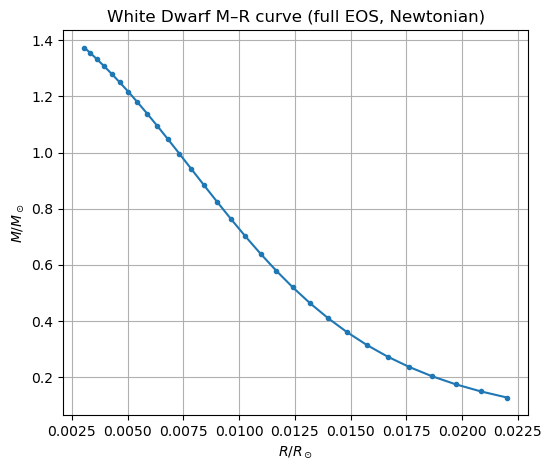

Max mass ~ 1.374720751796756 Msun at rho_c = 1584893192.4611108


In [24]:
rho_grid = np.logspace(5.0, 9.2, 30)  # slightly safer range

M_list = []
R_list = []

for rc in rho_grid:
    M_cgs, R_cgs = integrate_wd(rc)
    M_list.append(M_cgs/M_sun)
    R_list.append(R_cgs/R_sun)

M_list = np.array(M_list)
R_list = np.array(R_list)

order = np.argsort(R_list)

plt.figure(figsize=(6,5))
plt.plot(R_list[order], M_list[order], marker="o", ms=3)
plt.xlabel(r"$R/R_\odot$")
plt.ylabel(r"$M/M_\odot$")
plt.title("White Dwarf M–R curve (full EOS, Newtonian)")
plt.grid(True)
plt.savefig("../figures/wd_MR_fullEOS_newton.png", dpi=200, bbox_inches="tight")
plt.show()

imax = np.argmax(M_list)
print("Max mass ~", M_list[imax], "Msun at rho_c =", rho_grid[imax])


In [25]:

df = pd.read_csv("../data/white_dwarf_data.csv")

# columns in your file look like: wdid, logg, mass
logg = df["logg"].to_numpy()
M_obs = df["mass"].to_numpy()  # Msun

# convert logg -> g -> radius via g = GM/R^2
G = 6.67430e-8
M_sun = 1.98847e33
R_sun = 6.957e10

g_cgs = 10**logg
R_obs = np.sqrt(G * (M_obs*M_sun) / g_cgs) / R_sun  # in Rsun

print("Loaded N =", len(df))
print("R range:", R_obs.min(), R_obs.max())
print("M range:", M_obs.min(), M_obs.max())


Loaded N = 378
R range: 0.003322614249429639 0.023792183116328882
M range: 0.074 1.38


In [26]:


def MR_curve_for_D(D_value, npts=12):
    # update EOS D
    global D
    D = D_value

    # sweep rho_c 
    rho_grid = np.logspace(5.0, 9.2, npts)

    M_list = []
    R_list = []
    for rc in rho_grid:
        M_cgs, R_cgs = integrate_wd(rc)
        M_list.append(M_cgs/M_sun)
        R_list.append(R_cgs/R_sun)

    M_list = np.array(M_list)
    R_list = np.array(R_list)

    # sort by R increasing for spline
    order = np.argsort(R_list)
    R_sorted = R_list[order]
    M_sorted = M_list[order]

    return R_sorted, M_sorted


In [27]:
def error_for_D(D_value):
    R_th, M_th = MR_curve_for_D(D_value, npts=12)

    # smoothing spline (s=0 makes it interpolate exactly)
    spline = UnivariateSpline(R_th, M_th, s=0, k=3)

    # Only evaluate where data radii lie inside theoretical radius span
    mask = (R_obs >= R_th.min()) & (R_obs <= R_th.max())
    if mask.sum() < 5:
        return np.inf

    M_pred = spline(R_obs[mask])
    rms = np.sqrt(np.mean((M_pred - M_obs[mask])**2))
    return rms


In [28]:
D0 = D_K
D_grid1 = np.linspace(0.9*D0, 1.1*D0, 10)  
errs1 = []

for Dtest in D_grid1:
    e = error_for_D(Dtest)
    errs1.append(e)
    print("coarse D =", Dtest, "RMS error =", e)

errs1 = np.array(errs1)
D_coarse_best = D_grid1[np.argmin(errs1)]
print("\nCoarse best D =", D_coarse_best)

# --- refine around coarse best ---
D_grid2 = np.linspace(0.97*D_coarse_best, 1.03*D_coarse_best, 10)  
errs2 = []

for Dtest in D_grid2:
    e = error_for_D(Dtest)
    errs2.append(e)
    print("refine D =", Dtest, "RMS error =", e)

errs2 = np.array(errs2)
D_best = D_grid2[np.argmin(errs2)]

print("\nBest D =", D_best)
print("Best RMS error =", errs2.min())
print("ratio D_best / D_theory =", D_best/D_th)


coarse D = 1829274.849660875 RMS error = 0.14996020096849544
coarse D = 1874442.1298994152 RMS error = 0.09447635566060608
coarse D = 1919609.4101379553 RMS error = 0.04436706260542047
coarse D = 1964776.6903764955 RMS error = 0.009393689550202365
coarse D = 2009943.9706150356 RMS error = 0.04502071739492899
coarse D = 2055111.2508535758 RMS error = 0.08246287779221316
coarse D = 2100278.5310921157 RMS error = 0.11688850404108611
coarse D = 2145445.811330656 RMS error = 0.14890935637475441
coarse D = 2190613.0915691964 RMS error = 0.17800827825209767
coarse D = 2235780.3718077363 RMS error = 0.2049636812724252

Coarse best D = 1964776.6903764955
refine D = 1905833.3896652006 RMS error = 0.05907217175286826
refine D = 1918931.9009343772 RMS error = 0.045075273246149426
refine D = 1932030.4122035538 RMS error = 0.031685226925070434
refine D = 1945128.9234727304 RMS error = 0.01923169421333636
refine D = 1958227.434741907 RMS error = 0.00988980958412427
refine D = 1971325.946011084 RMS er

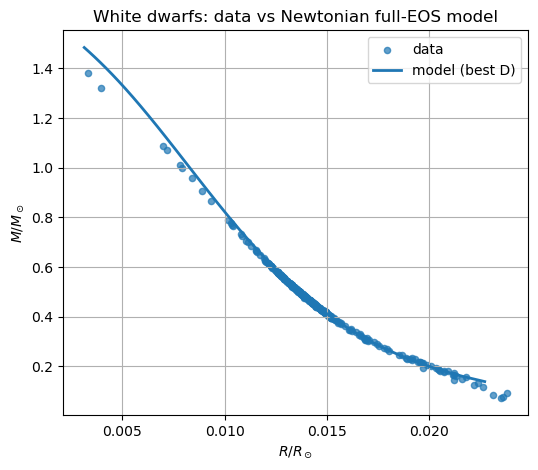

In [29]:
R_best, M_best = MR_curve_for_D(D_best, npts=35)

plt.figure(figsize=(6,5))
plt.scatter(R_obs, M_obs, s=20, alpha=0.7, label="data")
plt.plot(R_best, M_best, lw=2, label="model (best D)")

plt.xlabel(r"$R/R_\odot$")
plt.ylabel(r"$M/M_\odot$")
plt.title("White dwarfs: data vs Newtonian full-EOS model")
plt.grid(True)
plt.legend()

plt.savefig("../figures/wd_data_vs_model_bestD.png", dpi=200, bbox_inches="tight")
plt.show()


Best-fit D max mass = 1.5209277345712438 Msun at rho_c = 3162277660.1683793


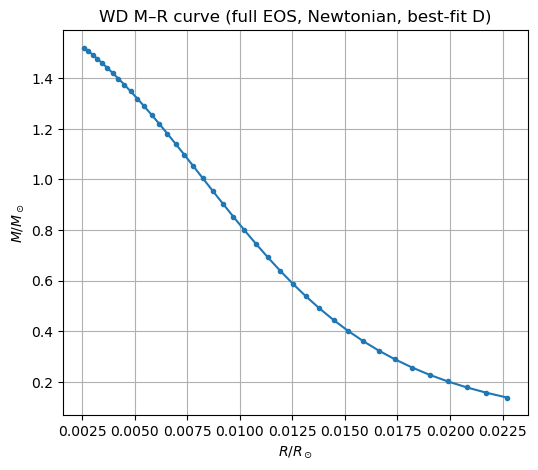

In [30]:
D = D_best

rho_grid = np.logspace(5.0, 9.5, 40)
M_list, R_list = [], []

for rc in rho_grid:
    M_cgs, R_cgs = integrate_wd(rc)
    M_list.append(M_cgs/M_sun)
    R_list.append(R_cgs/R_sun)

M_list = np.array(M_list)
R_list = np.array(R_list)

imax = np.argmax(M_list)
print("Best-fit D max mass =", M_list[imax], "Msun at rho_c =", rho_grid[imax])

order = np.argsort(R_list)
plt.figure(figsize=(6,5))
plt.plot(R_list[order], M_list[order], marker="o", ms=3)
plt.xlabel(r"$R/R_\odot$")
plt.ylabel(r"$M/M_\odot$")
plt.title("WD M–R curve (full EOS, Newtonian, best-fit D)")
plt.grid(True)
plt.savefig("../figures/wd_MR_fullEOS_bestD.png", dpi=200, bbox_inches="tight")
plt.show()

In [31]:
# Checking local power-law slope gamma_eff = d ln P / d ln rho at large rho
rhos = np.logspace(8, 12, 10)
Pvals = P_of_rho(rhos)

gamma_eff = np.gradient(np.log(Pvals), np.log(rhos))
print("gamma_eff at high rho:", gamma_eff)
print("should approach ~ 4/3 =", 4/3)



gamma_eff at high rho: [1.37113368 1.36463122 1.35448269 1.34887251 1.34587771 1.34431507
 1.34351146 1.34310189 1.34289428 1.34282456]
should approach ~ 4/3 = 1.3333333333333333


Best-fit D max mass = 1.6987692023528882 Msun at rho_c = 1000000000000.0


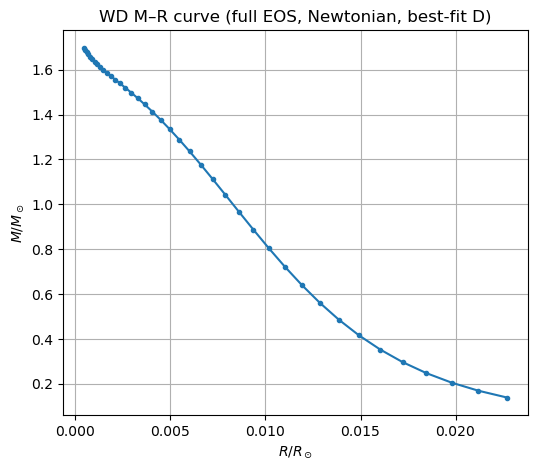

In [33]:
D = D_best

rho_grid = np.logspace(5.0, 12, 40)
M_list, R_list = [], []

for rc in rho_grid:
    M_cgs, R_cgs = integrate_wd(rc)
    M_list.append(M_cgs/M_sun)
    R_list.append(R_cgs/R_sun)

M_list = np.array(M_list)
R_list = np.array(R_list)

imax = np.argmax(M_list)
print("Best-fit D max mass =", M_list[imax], "Msun at rho_c =", rho_grid[imax])

order = np.argsort(R_list)
plt.figure(figsize=(6,5))
plt.plot(R_list[order], M_list[order], marker="o", ms=3)
plt.xlabel(r"$R/R_\odot$")
plt.ylabel(r"$M/M_\odot$")
plt.title("WD M–R curve (full EOS, Newtonian, best-fit D)")
plt.grid(True)
plt.savefig("../figures/wd_MR_fullEOS_bestD_bigger_scale.png", dpi=200, bbox_inches="tight")
plt.show()